In [1]:
# Data Science Corpus - Exploratory Data Analysis
# Working with JSONL files for semantic search

import polars as pl
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import re
import nltk
from nltk.corpus import stopwords
from pathlib import Path
import os
import sys
warnings.filterwarnings('ignore')


# Download stopwords if not already downloaded
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


In [2]:

# Set up paths - ensure we're working from project root
if Path.cwd().name == 'notebooks':
    project_root = Path.cwd().parent
else:
    project_root = Path.cwd()

# Add project root to path to import from src
sys.path.insert(0, str(project_root))

# Import utility functions from src.utils
from src.utils import read_jsonl, get_data_path, CLEAN_DATA_FILE, RAW_DATA_FILE

os.chdir(project_root)  # Change working directory to project root
print(f"Project root: {project_root}")
print(f"Using utility functions from src.utils")

Project root: /mnt/c/Users/jrems/Documents/DS-498/semantic_search
Using utility functions from src.utils


In [3]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# Load JSONL data

def load_jsonl(file_path):
    """Load JSONL file into a list of dictionaries"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

# Load the clean corpus data
jsonl_file = get_data_path(CLEAN_DATA_FILE)
print(f"Loading JSONL data from: {jsonl_file}")
print("Loading JSONL data...")
corpus_data = load_jsonl(str(jsonl_file))
print(f"Loaded {len(corpus_data)} records")

# Convert to DataFrame
df = pl.DataFrame(corpus_data)


Loading JSONL data from: /mnt/c/Users/jrems/Documents/DS-498/semantic_search/data/ds_corpus_clean.jsonl
Loading JSONL data...
Loaded 6428 records


In [5]:
df = pl.DataFrame(corpus_data)
df.head()

id,title,text,url
str,str,str,str
"""Artificial_intelligence_0""","""Artificial intelligence""","""Artificial intelligence (AI) i…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_1""","""Artificial intelligence""","""High-profile applications of A…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_2""","""Artificial intelligence""","""Various subfields of AI resear…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_3""","""Artificial intelligence""","""Artificial intelligence was fo…","""https://en.wikipedia.org/wiki/…"
"""Artificial_intelligence_4""","""Artificial intelligence""","""The general problem of simulat…","""https://en.wikipedia.org/wiki/…"


In [6]:
# Print the shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

# Display the schema
print("\nDataframe Schema:")
print(df.schema)

# Check for missing values
print("\nMissing Values:")
print(df.null_count())


Shape of the DataFrame: (6428, 4)

Dataframe Schema:
Schema([('id', String), ('title', String), ('text', String), ('url', String)])

Missing Values:
shape: (1, 4)
┌─────┬───────┬──────┬─────┐
│ id  ┆ title ┆ text ┆ url │
│ --- ┆ ---   ┆ ---  ┆ --- │
│ u32 ┆ u32   ┆ u32  ┆ u32 │
╞═════╪═══════╪══════╪═════╡
│ 0   ┆ 0     ┆ 0    ┆ 0   │
└─────┴───────┴──────┴─────┘


In [9]:
# Examine Document Lengths
df_with_stats = df.with_columns(
    pl.col("text").str.len_chars().alias("text_length")
)

# Shows stats for the text length column
# Note: df_with_stats is already a DataFrame (eager evaluation), so no .collect() needed
print("\nText Length Statistics:")
print(df_with_stats.select("text_length").describe())


Text Length Statistics:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ text_length │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 6428.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 387.643124  │
│ std        ┆ 235.085186  │
│ min        ┆ 150.0       │
│ 25%        ┆ 214.0       │
│ 50%        ┆ 319.0       │
│ 75%        ┆ 486.0       │
│ max        ┆ 2538.0      │
└────────────┴─────────────┘


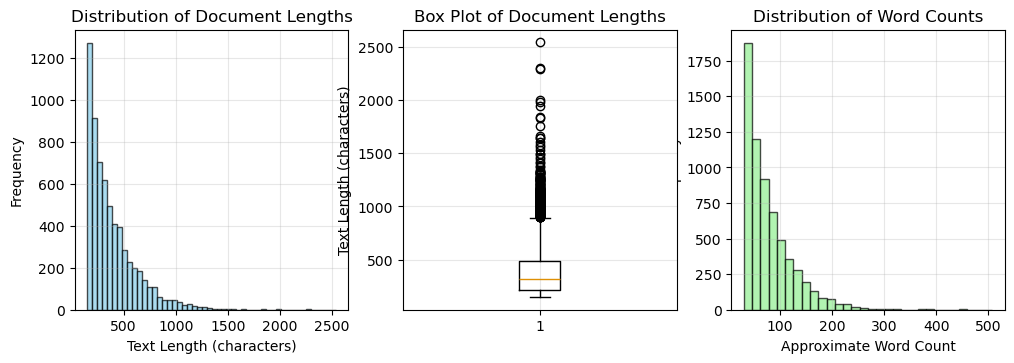

In [10]:
# Subplot 1: Histogram of text lengths
plt.subplot(2, 3, 1)
plt.hist(df_with_stats['text_length'].to_list(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.grid(True, alpha=0.3)


# Subplot 3: Word count distribution (approximate)
word_counts_per_doc = df_with_stats.with_columns(
    (pl.col("text_length") / 5).round().alias("approx_word_count")  # Rough estimate: 5 chars per word
)
plt.subplot(2, 3, 3)
plt.hist(word_counts_per_doc['approx_word_count'].to_list(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Approximate Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(True, alpha=0.3)

# Subplot 2: Box plot of text lengths
plt.subplot(2, 3, 2)
plt.boxplot(df_with_stats['text_length'].to_list(), vert=True)
plt.ylabel('Text Length (characters)')
plt.title('Box Plot of Document Lengths')
plt.grid(True, alpha=0.3)

In [11]:
# Calculate the frequency of each word in the 'text' column (excluding stop words)

# Create a list of stop words for filtering
stop_words_list = list(stop_words)

word_counts = ( 
    df.lazy()
    .select(pl.col("text").str.to_lowercase().str.split(" ").alias("words")
    )
    .explode("words")
    .filter(pl.col("words") != "")
    .filter(~pl.col("words").is_in(stop_words_list))  # Filter out stop words
    .filter(pl.col("words").str.len_chars() > 2)  # Filter out very short words
    .group_by("words")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
    .limit(20)
    .collect()
)

print("Top 20 words by frequency:")
print(word_counts)



Top 20 words by frequency:
shape: (20, 2)
┌─────────────┬───────┐
│ words       ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ data        ┆ 2756  │
│ used        ┆ 1325  │
│ model       ┆ 1244  │
│ learning    ┆ 1024  │
│ one         ┆ 976   │
│ …           ┆ …     │
│ models      ┆ 554   │
│ function    ┆ 549   │
│ number      ┆ 534   │
│ information ┆ 508   │
│ example,    ┆ 467   │
└─────────────┴───────┘


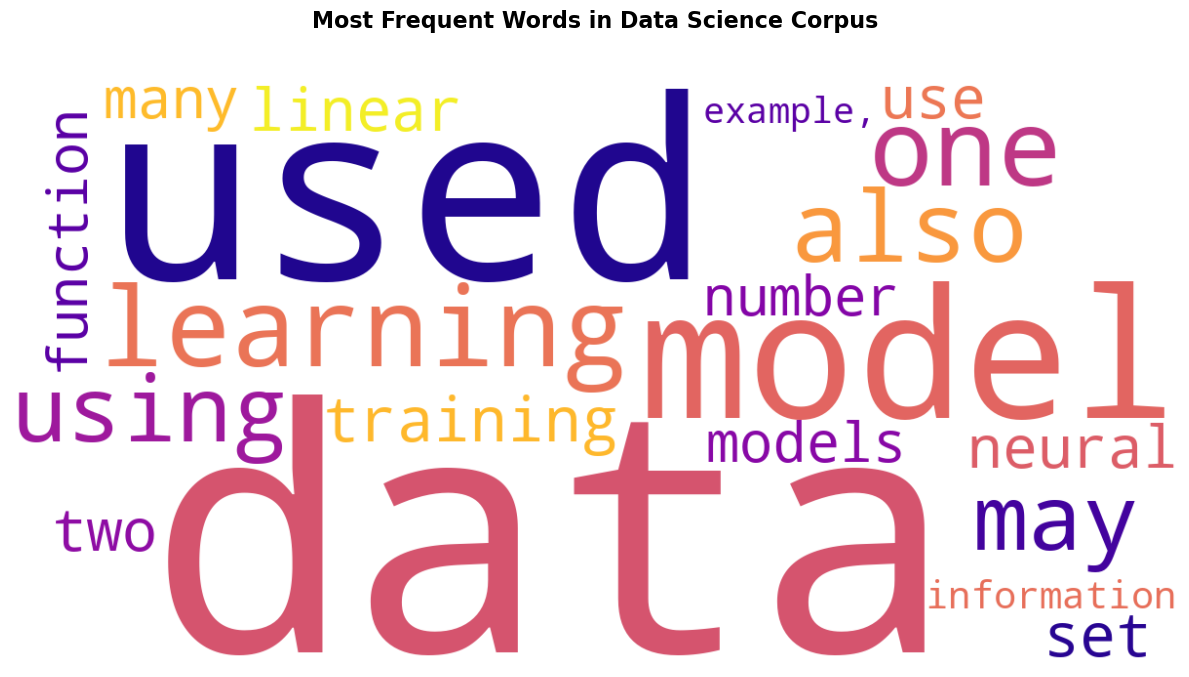

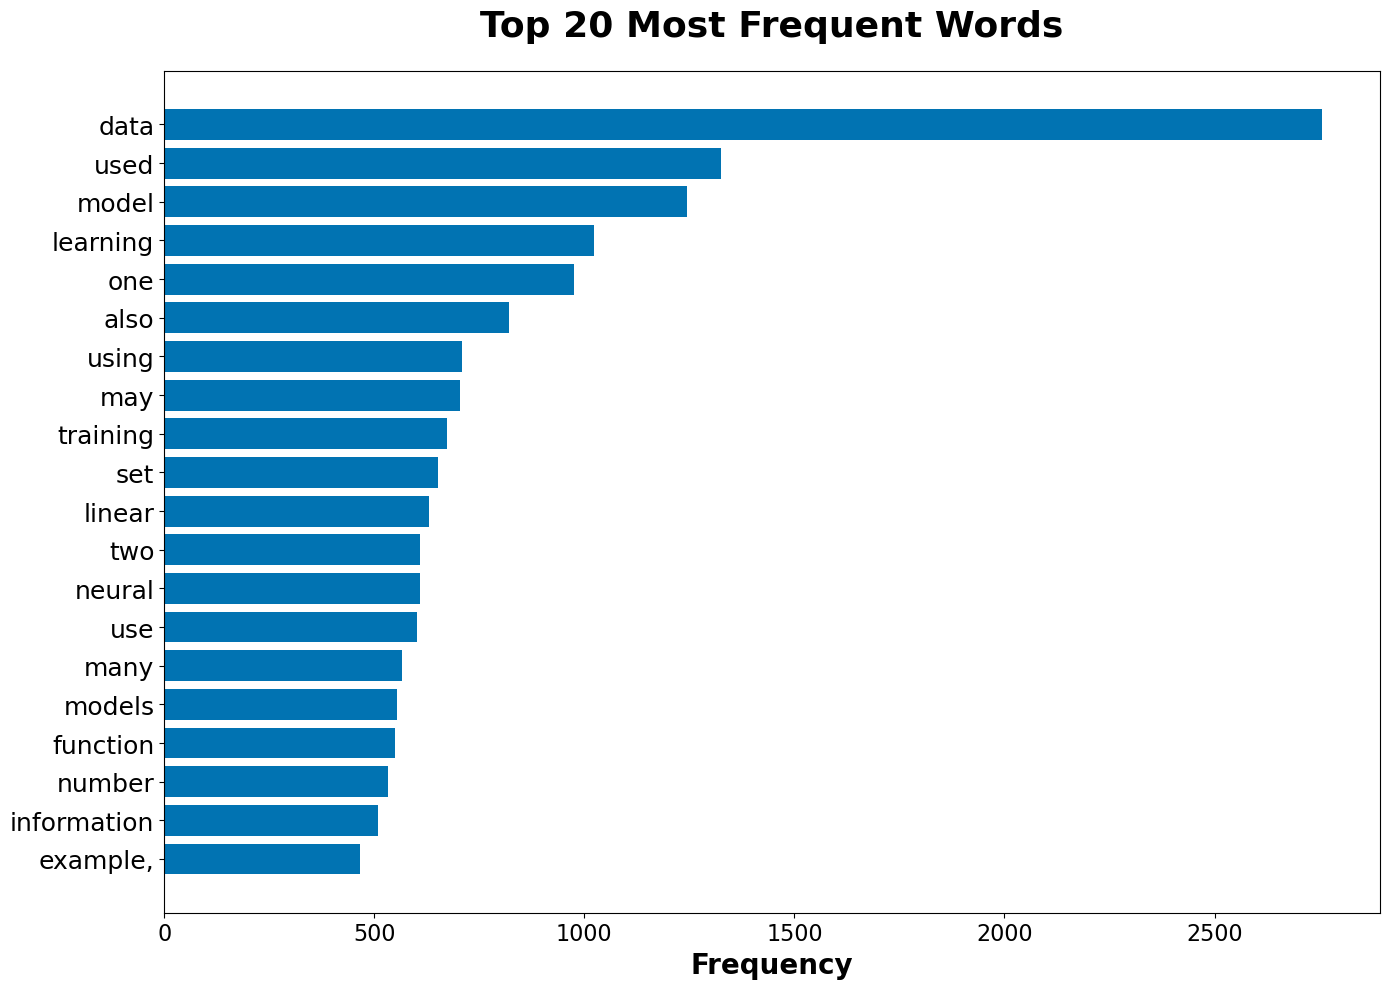

In [13]:
# Convert the word counts to a dictionary for WordCloud
word_freq_dict = dict(zip(word_counts['words'].to_list(), word_counts['count'].to_list()))

# Create the word cloud
wordcloud = WordCloud(
    width=1200, 
    height=600, 
    background_color='white',
    colormap='plasma',  
    max_words=50,  # Show top 50 words
    relative_scaling=0.5,
    random_state=42
).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Data Science Corpus\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Also show the top 20 words as a bar chart for comparison
top_20 = word_counts.head(20)
plt.figure(figsize=(14, 10))  # Make figure larger for better readability
plt.barh(range(len(top_20)), top_20['count'].to_list())
plt.yticks(range(len(top_20)), top_20['words'].to_list(), fontsize=18)  # Much larger y-axis labels
plt.xlabel('Frequency', fontsize=20, fontweight='bold')  # Larger x-axis label
plt.title('Top 20 Most Frequent Words', fontsize=26, fontweight='bold', pad=25)  # Much larger title
plt.tick_params(axis='x', labelsize=16)  # Larger x-axis tick labels
plt.gca().invert_yaxis()  # Show highest frequency at top
plt.tight_layout()
plt.show()
